# <a href="https://girafe.ai/" target="_blank" rel="noopener noreferrer"><img src="https://raw.githubusercontent.com/girafe-ai/ml-course/7096a5df4cada5ee651be1e3215c2f7fb8a7e0bf/logo_margin.svg" alt="girafe-ai logo" width="150px" align="left"></a> [ml-basic course](https://github.com/girafe-ai/ml-course) <a class="tocSkip">

# Lab assignment №1, part 2
## Gradient boosting on temporal data and feature importances

Today we will work with Gradient Boosting library. It is one of the most popular models these days that shows both great quality and performance.

Choises for library are:

* [LightGBM](https://github.com/Microsoft/LightGBM) by Microsoft. Handful and fast.
* [Catboost](https://github.com/catboost/catboost) by Yandex. Tuned to deal well with categorical features.
* [xgboost](https://github.com/dmlc/xgboost) by dlmc. The most famous framework which got very popular on kaggle.

**Dataset**

By default we will work with widely known [Human Actividy Recognition (HAR) dataset](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones). Data is available at UCI repository.

There are available both raw and preprocessed datasets. This time we will use the preprocessed one.
Some simple preprocessing is done for you.

If you want more interpretable data, you can take [Wine quality dataset](https://archive.ics.uci.edu/dataset/186/wine+quality) (see details below).

Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset and try to get some useful insights on the features the model paid attention to.

_Despite the main language of this notebook is English, feel free to write your thoughts in Russian._

## Part 0. Downloading and preprocessing

The preprocessing is done for you. Let's take a look at the data:

In [1]:
# Download and unpack dataset from UCI
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip -u "UCI HAR Dataset.zip" "UCI HAR Dataset/train/X_train.txt" "UCI HAR Dataset/train/y_train.txt" \
"UCI HAR Dataset/test/X_test.txt" "UCI HAR Dataset/test/y_test.txt" "UCI HAR Dataset/activity_labels.txt"

zsh:1: command not found: wget
unzip:  cannot find or open UCI HAR Dataset.zip, UCI HAR Dataset.zip.zip or UCI HAR Dataset.zip.ZIP.


In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
X_train = np.genfromtxt("UCI HAR Dataset/train/X_train.txt")
y_train = np.genfromtxt("UCI HAR Dataset/train/y_train.txt")
print(f"Train set: {X_train.shape}, {y_train.shape}")

X_test = np.genfromtxt("UCI HAR Dataset/test/X_test.txt")
y_test = np.genfromtxt("UCI HAR Dataset/test/y_test.txt")
print(f"Test set: {X_test.shape}, {y_test.shape}")

n_features = X_train.shape[1]

Train set: (7352, 561), (7352,)
Test set: (2947, 561), (2947,)


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
data_train = {
    'Cat': y_train,
}

data_test = {
    'Cat': y_test,
}

df_train = pd.DataFrame(data_train)
df_test = pd.DataFrame(data_test)

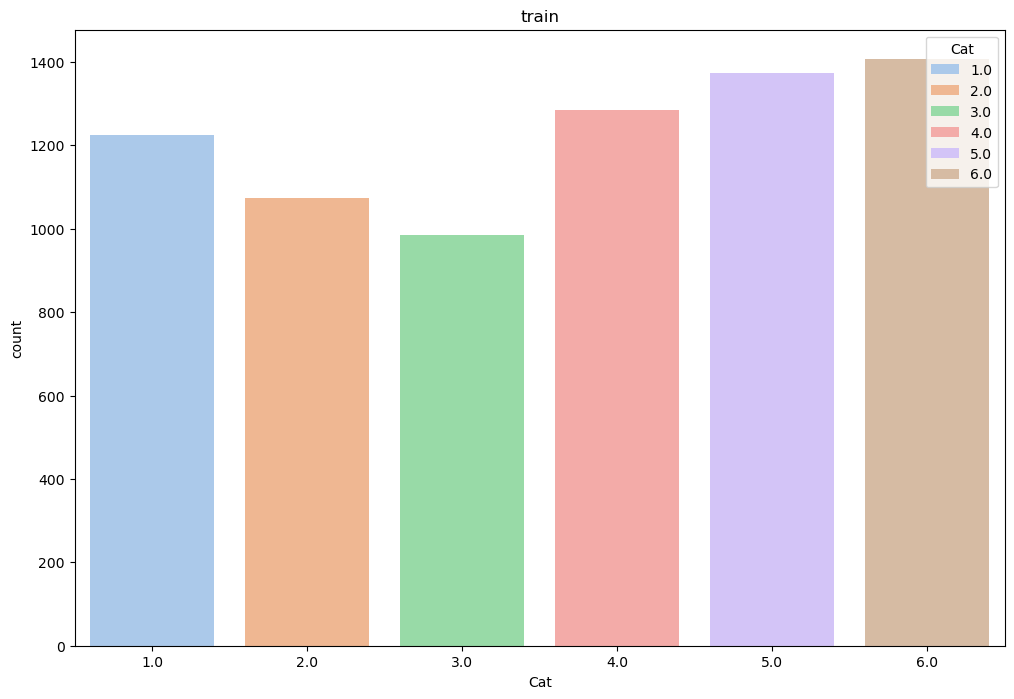

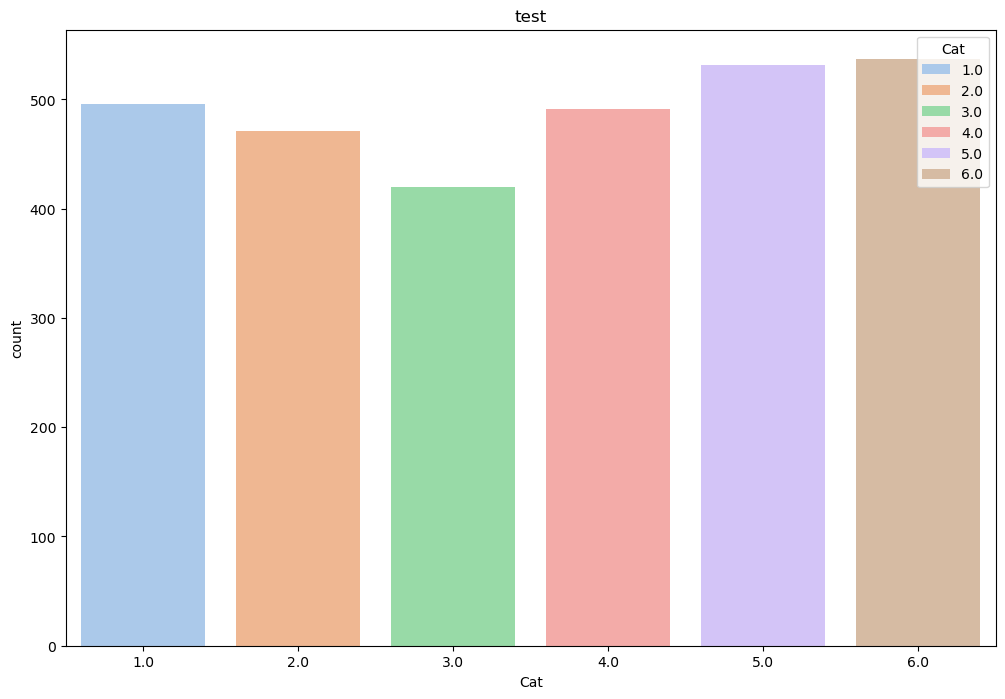

In [6]:
plt.figure(figsize=(12,8))
sns.countplot(x = 'Cat', data = df_train, hue = 'Cat', palette = 'pastel')
plt.title('train')
plt.show()

plt.figure(figsize=(12,8))
sns.countplot(x = 'Cat', data = df_test, hue = 'Cat', palette = 'pastel')
plt.title('test')
plt.show()

Как можно видеть, классы сбалансированы.

In [8]:
activity_labels = {}
with open("UCI HAR Dataset/activity_labels.txt", "r") as file:
    for line in file:
        label, name = line.strip().split(" ")
        activity_labels[int(label)] = name

activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

Let's normalize data

In [10]:
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean) / data_std
X_test = (X_test - data_mean) / data_std

The dataset has some duplicating features. Let's remove them

In [12]:
# fmt: off
duplicating_columns = (
    205, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 231, 244, 257, 507, 520, 533, 546,
)
# fmt: on

duplicating_mask = np.isin(range(n_features), duplicating_columns)

In [48]:
X_train_unique = X_train[:, ~duplicating_mask]
X_test_unique = X_test[:, ~duplicating_mask]

X_train_unique.shape, X_test_unique.shape

((7352, 540), (2947, 540))

PCA could be useful in this case. E.g.

In [51]:
from sklearn.decomposition import PCA

In [53]:
pca = PCA(0.99)

X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

X_train_pca.shape, X_test_pca.shape

((7352, 179), (2947, 179))

Text(0, 0.5, 'Principal component 2')

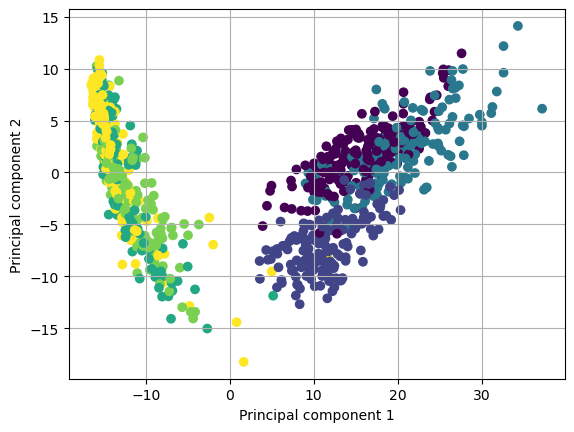

In [54]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")

Text(0, 0.5, 'Principal component 5')

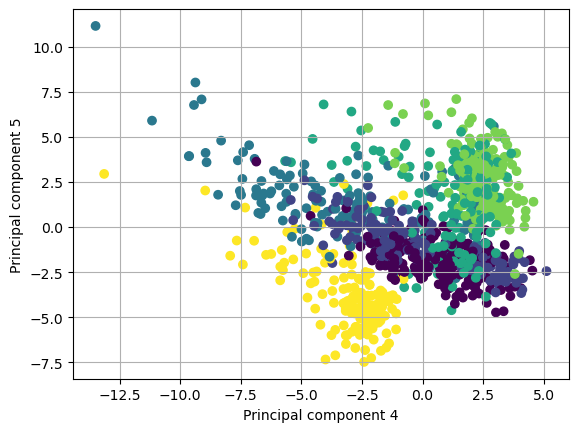

In [57]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 4")
plt.ylabel("Principal component 5")

### Alternative dataset: Wine quality

Please, take this dataset if you are sure you can preprocess it yourself and ready to work with it's features and results, so it is done on your risk.

However you will have interpretable features which can be analysed with shap in last part

In [29]:
!pip install ucimlrepo

In [32]:
import ucimlrepo as uci

In [34]:
dataset = uci.fetch_ucirepo(id=186)

print(dataset.metadata.name, '\n')
print(dataset.metadata.abstract, '\n')
print(dataset.metadata.additional_info.summary, '\n')

Wine Quality 

Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/). 

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult: http://www.vinhoverde.pt/en/ or the reference [Cortez et al., 2009].  Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks.  The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to t

## Part 1. Fit the model.

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to approximate them by yourself.

In this part just check some (3-5) sets of hyperparameters by hand.

In [39]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [59]:
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score

In [61]:
train_dataset = Pool(data = X_train_pca, label = y_train)
test_dataset = Pool(data = X_test_pca, label = y_test)

In [52]:
def UC_data_CatBoost(iter, lr, dp):
    model = CatBoostClassifier(iterations = iter,
                           learning_rate = lr,
                           depth = dp,
                           loss_function = 'MultiClass')
    
    model.fit(train_dataset, plot = True, verbose = False)
    preds_class = model.predict(test_dataset)
    preds_proba = model.predict_proba(test_dataset)
    
    print(classification_report(y_test, preds_class))
    print(f'ACCURACY = {accuracy_score(y_test, preds_class)}')

In [54]:
UC_data_CatBoost(100, 0.5, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

              precision    recall  f1-score   support

         1.0       0.85      0.96      0.91       496
         2.0       0.93      0.91      0.92       471
         3.0       0.92      0.81      0.86       420
         4.0       0.90      0.81      0.86       491
         5.0       0.85      0.92      0.89       532
         6.0       0.99      0.99      0.99       537

    accuracy                           0.91      2947
   macro avg       0.91      0.90      0.90      2947
weighted avg       0.91      0.91      0.91      2947

ACCURACY = 0.9056667797760435


In [56]:
UC_data_CatBoost(100, 0.8, 4)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

              precision    recall  f1-score   support

         1.0       0.84      0.95      0.89       496
         2.0       0.91      0.87      0.89       471
         3.0       0.90      0.80      0.85       420
         4.0       0.89      0.86      0.88       491
         5.0       0.88      0.91      0.90       532
         6.0       0.99      0.99      0.99       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947

ACCURACY = 0.9029521547336274


In [57]:
UC_data_CatBoost(50, 0.2, 6)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

              precision    recall  f1-score   support

         1.0       0.82      0.95      0.88       496
         2.0       0.91      0.90      0.91       471
         3.0       0.88      0.72      0.79       420
         4.0       0.89      0.84      0.86       491
         5.0       0.86      0.92      0.89       532
         6.0       0.99      0.98      0.98       537

    accuracy                           0.89      2947
   macro avg       0.89      0.88      0.89      2947
weighted avg       0.89      0.89      0.89      2947

ACCURACY = 0.8903970139124533


In [58]:
UC_data_CatBoost(150, 0.3, 9)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

              precision    recall  f1-score   support

         1.0       0.89      0.97      0.93       496
         2.0       0.92      0.94      0.93       471
         3.0       0.93      0.81      0.87       420
         4.0       0.90      0.86      0.88       491
         5.0       0.88      0.92      0.90       532
         6.0       0.99      0.99      0.99       537

    accuracy                           0.92      2947
   macro avg       0.92      0.91      0.92      2947
weighted avg       0.92      0.92      0.92      2947

ACCURACY = 0.9182219205972175


In [76]:
UC_data_CatBoost(500, 0.48, 7)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

              precision    recall  f1-score   support

         1.0       0.91      0.96      0.93       496
         2.0       0.93      0.94      0.94       471
         3.0       0.94      0.88      0.91       420
         4.0       0.92      0.88      0.90       491
         5.0       0.90      0.93      0.92       532
         6.0       0.99      0.99      0.99       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947

ACCURACY = 0.9328130302002036


In [77]:
UC_data_CatBoost(1000, 0.48, 7)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

              precision    recall  f1-score   support

         1.0       0.92      0.97      0.94       496
         2.0       0.94      0.95      0.94       471
         3.0       0.95      0.89      0.92       420
         4.0       0.93      0.89      0.91       491
         5.0       0.91      0.94      0.92       532
         6.0       0.99      0.99      0.99       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947

ACCURACY = 0.9402782490668476


## Part 2. Use hyper parameter tuning system

Use [optuna](https://optuna.org/), [hyperopt](http://hyperopt.github.io/hyperopt/) or any other zero order optimizer to find optimal hyper param set.

In [148]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 2.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 556.1 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [64]:
import optuna
from sklearn.model_selection import train_test_split

In [68]:
X_train_pca, X_valid_pca, y_train, y_valid = train_test_split(X_train_pca, y_train, test_size= 0.2)

def objective(trial):
    
    iterations = trial.suggest_int('iterations', 10, 200, step = 10)
    learning_rate = trial.suggest_float('learning_rate', 0.1, 1)
    depth = trial.suggest_int('depth', 1, 10)
    model = CatBoostClassifier(iterations = iterations,
                           learning_rate = learning_rate,
                           depth = depth,
                           loss_function = 'MultiClass', verbose=False)
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_valid_pca)
    acc_score = accuracy_score(y_valid, y_pred)
    
    return acc_score

study = optuna.create_study(study_name = "optim_for_catboost", direction="maximize")
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials = 100)
print(study.best_params)

{'iterations': 200, 'learning_rate': 0.48152133897824057, 'depth': 7}


In [70]:
print(study.best_params)
print(f'ACCURACY = {study.best_value}')

{'iterations': 200, 'learning_rate': 0.48152133897824057, 'depth': 7}
ACCURACY = 0.9609175870858114


In [80]:
model = CatBoostClassifier(iterations = 500,
                           learning_rate = 0.48,
                           depth = 7,
                           loss_function = 'MultiClass')
    
model.fit(train_dataset, plot = True, verbose = False)
preds_class = model.predict(test_dataset)
preds_proba = model.predict_proba(test_dataset)
    
print(classification_report(y_test, preds_class))
print(f'ACCURACY = {accuracy_score(y_test, preds_class)}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

              precision    recall  f1-score   support

         1.0       0.91      0.96      0.93       496
         2.0       0.93      0.94      0.94       471
         3.0       0.94      0.88      0.91       420
         4.0       0.92      0.88      0.90       491
         5.0       0.90      0.93      0.92       532
         6.0       0.99      0.99      0.99       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947

ACCURACY = 0.9328130302002036


### Conclusion



Как можно видеть из результатов работы optuna, наилучшая губина деревьев - это 7, хотя диапазон перебора был указан от 1 до 10, что говорит о том что при глубине деревьев более 7, модель скорее всего переобучается. Что касается параметра learning_rate, то оптимальным значением стала величина 0.48, при диапазоне значений от 0 до 1, с плавающей точкой. 

Значение iteration приняло максимальное значение в сетке перебора 200, что логично, ведь чем больше деревьев используется, тем ближе к правильному значению 'подбирается' модель. Например, при значении параметров iter = 500, lr = 0.48, depth = 4 (приведено в конце Part 1), значение ACCURACY = 0.93. Причем при увеличении iter до 1000, ACCURACY примерно равен 0.94, что говорит о том, что усложнение модели не имеет смысла. Поэтому оптимальное значение параметров iter = 500, lr = 0.48, depth = 7. 


## Part 3. Interpret the model predictions

Please use [shap](https://github.com/slundberg/shap) to build some plots and try to interpret them.

In [315]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.3/455.3 kB 2.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [38]:
import shap
shap.initjs()

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [63]:
model = CatBoostClassifier(iterations = 500,
                           learning_rate = 0.404,
                           depth = 4,
                           loss_function = 'MultiClass')
    
model.fit(train_dataset, plot = True, verbose = False)
preds_class = model.predict(test_dataset)
preds_proba = model.predict_proba(test_dataset)
    
print(classification_report(y_test, preds_class))
print(f'ACCURACY = {accuracy_score(y_test, preds_class)}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

              precision    recall  f1-score   support

         1.0       0.92      0.98      0.95       496
         2.0       0.93      0.95      0.94       471
         3.0       0.97      0.87      0.92       420
         4.0       0.94      0.88      0.91       491
         5.0       0.90      0.95      0.93       532
         6.0       0.99      1.00      1.00       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947

ACCURACY = 0.9416355615880556


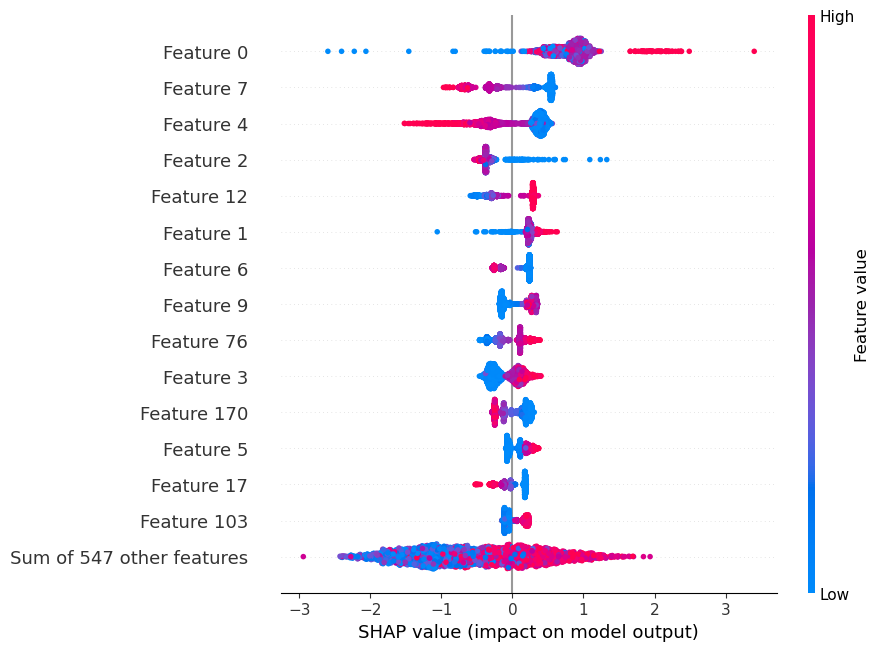

In [69]:
plt.legend("", frameon=False)
plt.title("")
plt.ylabel("")
explainer: shap.explainers.Tree = shap.TreeExplainer(model)
shap_values: shap.Explanation = explainer(X_test)
shap.plots.beeswarm(shap_values[:,:,0], max_display=15, show=True)

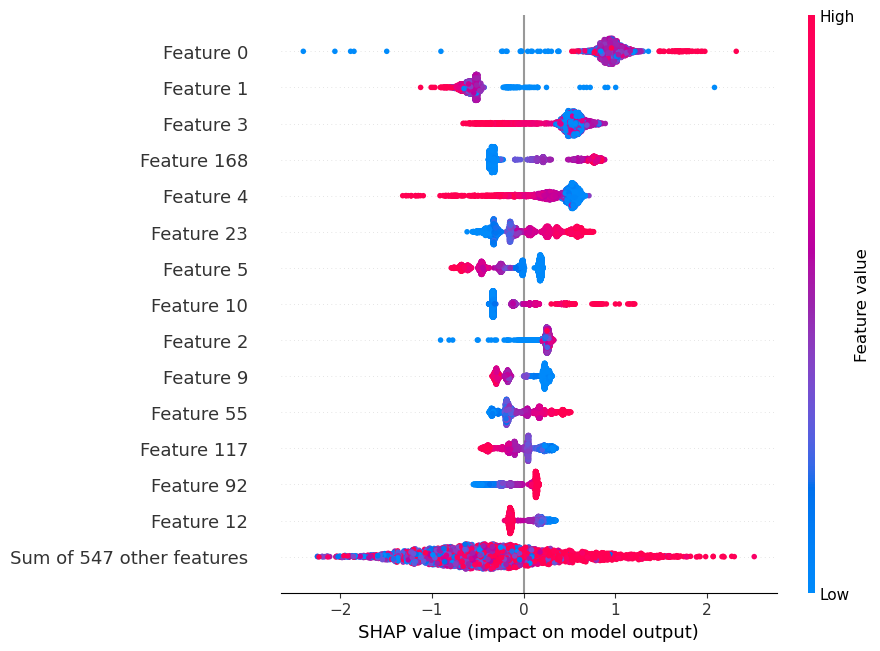

In [71]:
shap.plots.beeswarm(shap_values[:,:,1], max_display=15, show=True)

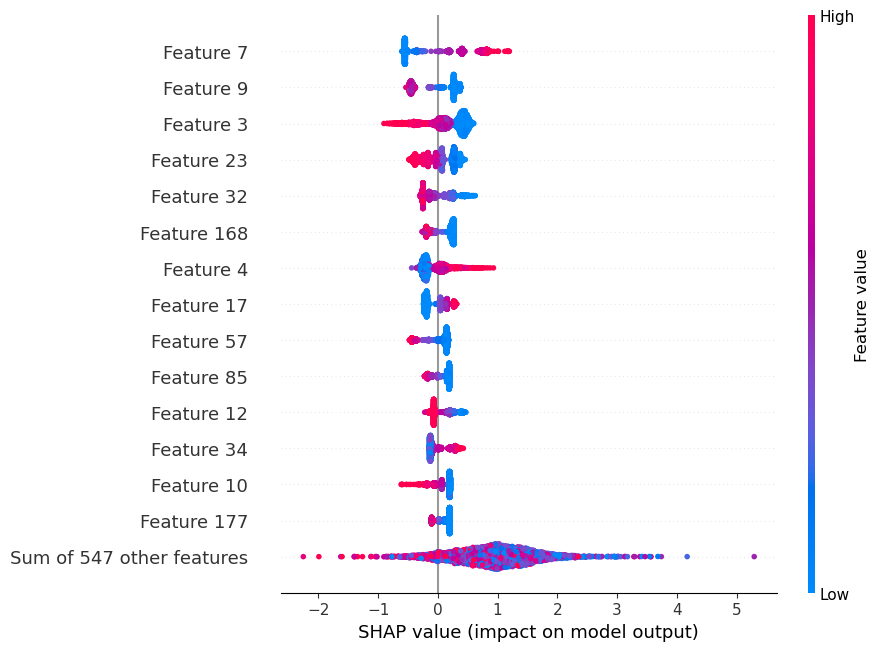

In [79]:
shap.plots.beeswarm(shap_values[:,:,2], max_display=15, show=True)

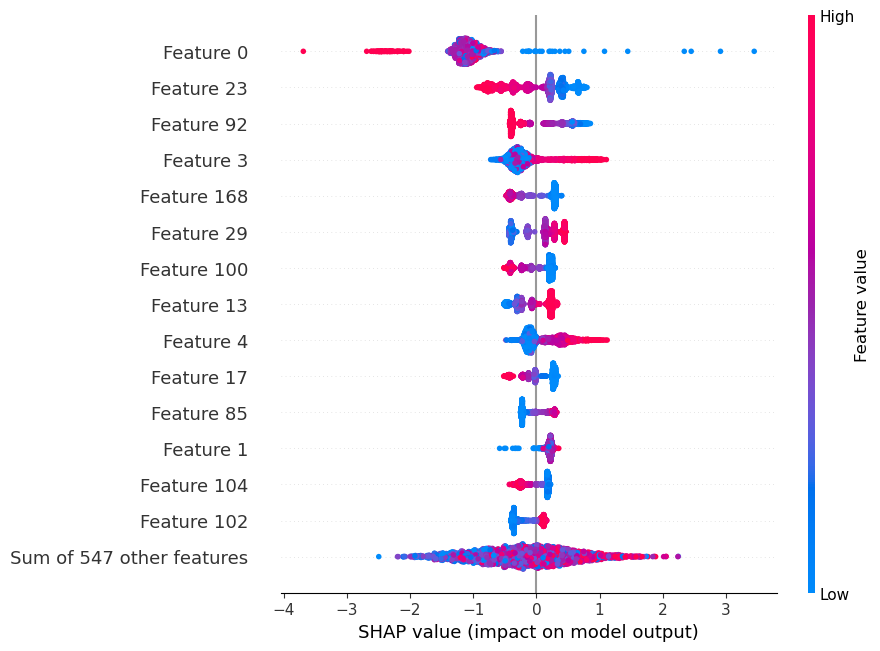

In [73]:
shap.plots.beeswarm(shap_values[:,:,3], max_display=15, show=True)

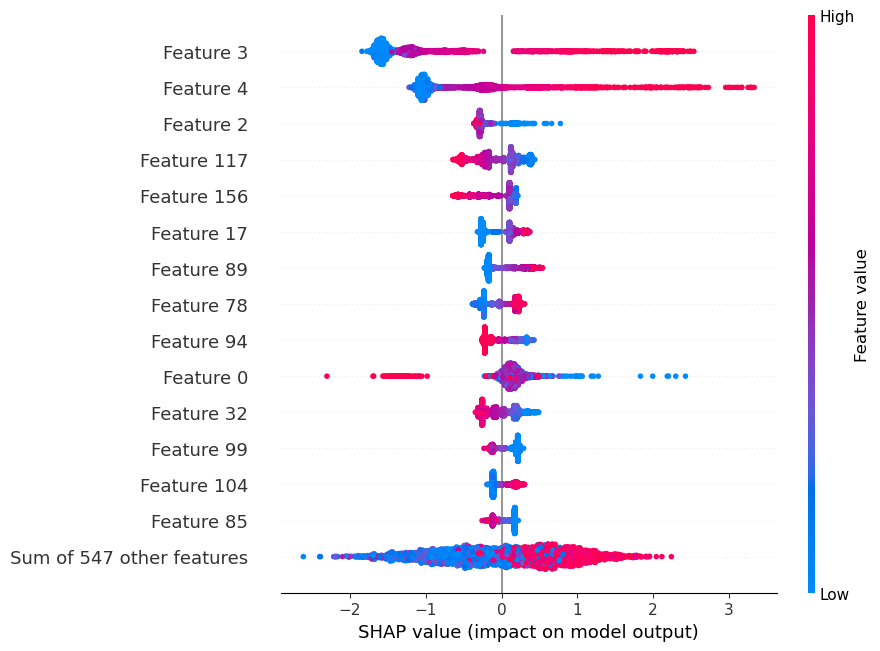

In [75]:
shap.plots.beeswarm(shap_values[:,:,4], max_display=15, show=True)

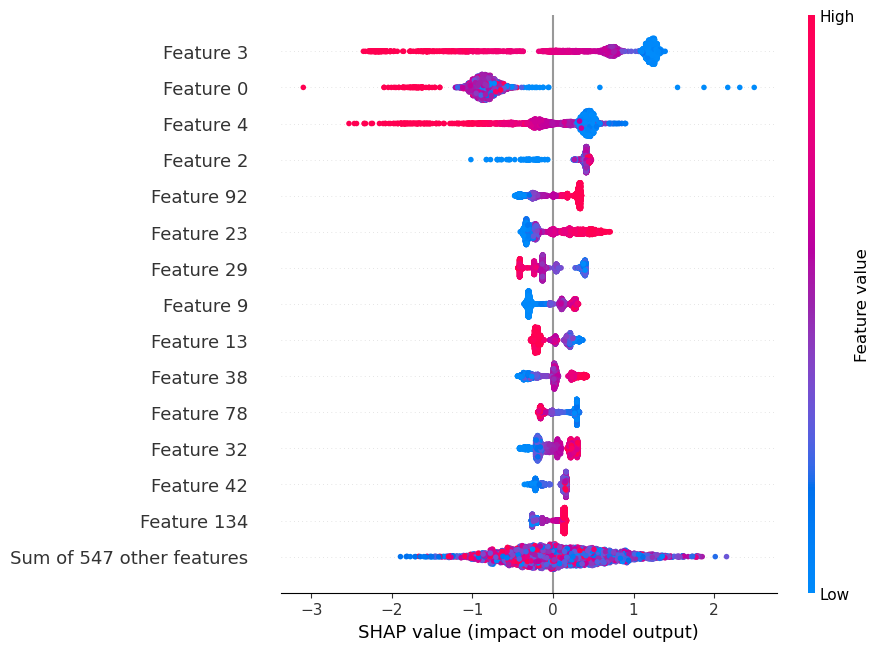

In [77]:
shap.plots.beeswarm(shap_values[:,:,5], max_display=15, show=True)

### Conclusion

Согласно SHAP наиболее важной фичей является фича 0, помимо нее фича 3, 4, 7 так же достаточно часто являются основными в раличных классах. Преобразование PCA наделяет эти оси наибольшей информацией.